# Chapter 5. The Many Variables & The Spurious Waffles

In [1]:
%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
from utils import *

In [3]:
import altair as alt
import pandas as pd

In [4]:
import arviz as az
from causalgraphicalmodels import CausalGraphicalModel
import daft
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd

from jax import lax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

### Code 5.1

In [5]:
# load data and copy
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())

In [6]:
print(d.shape)
d.head()


(50, 15)


,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.927058


### Code 5.2

In [7]:
d.MedianAgeMarriage.std()

1.2436303013880823

### Code 5.3 model 5_1: D ~ A

We use a SVI object to find our parameter values for the approximating distribution `m5_1`. 

Note: `m5_1` has no data in it. But `m5_1(p5_1)` is a callable object. It should approximate $P(D,A)$ somehow.

`model -> AutoLaplace -> m5_1 -> SVI -> A,D -> state -> p5_1`

In [8]:
def model(A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bA * A
#     do we do this so we can fetch mu out of it later?? me thinks so.
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), AutoContinuousELBO(),
          A=d.A.values, D=d.D.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
# p5_1 are the parameters that the approximating distribution use to describe the model distribution
p5_1 = svi.get_params(state)

In [9]:
p5_1

{'auto_loc': DeviceArray([ 7.2371108e-08, -5.6785572e-01, -2.2795624e-01], dtype=float32)}

### Code 5.4 - prior predictive of $\mu$ (for D) model 5_1 with A=-2,2

this gives us an idea of what the most likely values for `D` are, given our assumptions about `a` and `bA` 

We use function `Predictive` to create an object `predictive` that will generate a sample of values for a give _site_ or variable. Later, we will call `Predictive` with a dictionary of generated values for the sites. This will give us a _posterior_ prediction.

> m5_1.model -> Predictive -> get_samplesA=[-2,2]) -> prior_pred -> mu

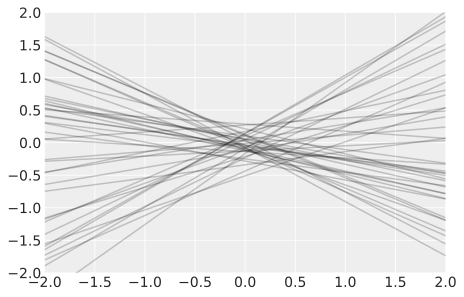

In [10]:
# m5_1 has no data in it
# p5_1 has the parameters for the model _and_ the data

predictive = Predictive(m5_1.model, num_samples=1000, return_sites=["mu"])
prior_pred = predictive.get_samples(PRNGKey(10), A=np.array([-2, 2]))
mu = prior_pred["mu"]
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(40):
    plt.plot([-2, 2], mu[i], "k", alpha=0.2)

In [11]:
# shape determined by num_samples and shape of A
prior_pred['mu'].shape

(1000, 2)

In [12]:
# m5_1 has no data in it
# p5_1 has the parameters for the model _and_ the data
# Predictive is not taking any parameter for the samples of the model parameters
# note: "predictive" is for generating a the dependent variable

predictive = Predictive(m5_1.model, num_samples=1000, return_sites=["mu"])

prior_pred = predictive.get_samples(PRNGKey(10), A=np.array([-2, 2]))
mu = prior_pred["mu"]

pd_df = pd.DataFrame({'mu_0' :prior_pred['mu'][:,0], 'mu_1' : prior_pred['mu'][:,1]})

In [13]:
# d_df.head().T.reset_index().melt()
d_df.head().T.melt().reset_index()

,index,variable,value
0,0,0,-0.285605
1,1,0,0.031658
2,2,1,-1.218851
3,3,1,1.432945
4,4,2,0.405135
5,5,2,-0.471566
6,6,3,0.298279
7,7,3,-0.865868
8,8,4,-0.641975
9,9,4,0.396169


In [21]:
d_df

,mu_0,mu_1
0,-0.285605,0.031658
1,-1.218851,1.432945
2,0.405135,-0.471566
3,0.298279,-0.865868
4,-0.641975,0.396169
...,...,...
995,-1.284102,0.723273
996,0.411186,-0.020097
997,-0.288634,0.179580
998,-0.528369,0.020925


## Definition of plot lines..

In [14]:
# plot_lines(d_df[:40].T.values ).properties(width=800, height=400)
plot_lines(d_df[:40].T.values, options={'opacity':0.3}).properties(width=800, height=400)

alt.Chart(...)

In [22]:
from altair import datum
d2_df = d_df.head(40).T.melt().reset_index()


alt.Chart(d2_df).transform_calculate(
    new_x = datum.index % 2).mark_line().encode(
    x = "new_x:Q",
    y = "value:Q",
    detail = "variable:O"  # <<<<<<<<< 
    )
    

alt.Chart(...)

### Code 5.5 

Here, we generate `post` which is a sample of parameters generated from `m5_1` using the parameters `p5_1`. Recall, `p5_1` were created from the `svi` object using `m5_1` and the data `A` and `D`. 

We then feed those generated parameters (_posteriors_) back into our model using `Predictive` and `get_samples` to generate new values of `mu` for`D` relative to the synthetic values of `A`.

In [23]:
# compute percentile interval of mean
A_seq = np.linspace(start=-3, stop=3.2, num=30)

# post is a sample from the posterior distribution of the model parameter using the description p5_1 
post = m5_1.sample_posterior(PRNGKey(1), p5_1, (1000,))

# in this case, Predictive is using a second parameter "post" to generate the dependent variable Divorce
post_pred = Predictive(m5_1.model, post).get_samples(PRNGKey(2), A=A_seq)

mu = post_pred["mu"]
mu_mean = np.mean(mu, 0) # shape (30,)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)

mu_df = pd.DataFrame({'mu_pi_l': mu_PI[0], 'mu_pi_h': mu_PI[1], 'mu_mean': mu_mean, 'idx': A_seq})

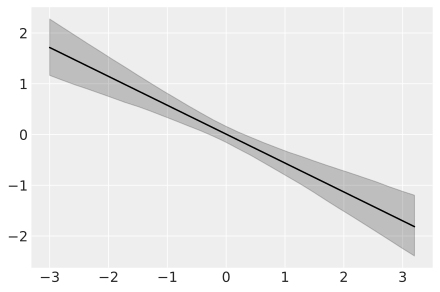

In [23]:
# plot it all
az.plot_pair(d[["D", "A"]].to_dict(orient="list"), backend='bokeh')
plt.plot(A_seq, mu_mean, "k")
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);

In [24]:
# goal: create chart with sample of mu drawn in (not just shaded)
base = alt.Chart(d)

c_points = base.mark_point().encode(
    y = alt.Y('D:Q', title = 'Divorce'),
    x = alt.X('A:Q', title = 'Age'),
    tooltip = ['Location']
).properties(width=700, title="")

mu_base = alt.Chart(mu_df)

c_line = mu_base.mark_line().encode(
    x = alt.X('idx:Q'),
    y = alt.Y('mu_mean:Q')
)

c_area = mu_base.mark_area(opacity=0.3).encode(
    x = alt.X('idx:Q' ),
    y = 'mu_pi_l:Q',
    y2 = 'mu_pi_h:Q')

(c_line + c_area + c_points).properties(title="Divorce ~ Median Age : shade area is 96 percentile $\mu$")

alt.LayerChart(...)

### Code 5.6 Model 5_2: D ~ M

In [139]:
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

def model(M, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), AutoContinuousELBO(),
          M=d.M.values, D=d.D.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_2 = svi.get_params(state)

### Code 5.7

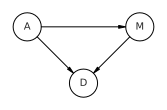

In [140]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M"),
           ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [141]:
daft.__version__

'0.1.0'

### Code 5.8

In [98]:
DMA_dag2 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

('D', 'M', {'A'})


### Code 5.9

In [99]:
DMA_dag2 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M"),
           ("M", "D")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

### Code 5.10 Model 5_3: D ~ M + A

In [165]:
def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_3 = AutoLaplaceApproximation(model)
svi = SVI(model, # that which we're trying to hit
          m5_3, #guide (that which we're going to optimize)
          optim.Adam(1), # optimizing method (gradient thing)
          AutoContinuousELBO(), #loss function
          M=d.M.values, 
          A=d.A.values, 
          D=d.D.values
         )
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_3 = svi.get_params(state)
post = m5_3.sample_posterior(PRNGKey(1), p5_3, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.16      0.14   1049.96      1.00
        bA     -0.62      0.16     -0.62     -0.87     -0.37    822.38      1.00
        bM     -0.05      0.16     -0.05     -0.30      0.21    985.05      1.00
     sigma      0.80      0.08      0.80      0.68      0.92    962.65      1.00



In [236]:
post_df = pd.DataFrame(post)
post_df

,a,bA,bM,sigma
0,-0.095199,-0.790629,0.011654,0.806361
1,0.083045,-0.787839,-0.213877,0.686171
2,0.136928,-0.804418,-0.066496,0.831465
3,0.110449,-0.518739,0.064718,0.862551
4,0.136790,-0.600922,-0.092877,0.762157
...,...,...,...,...
9995,-0.189911,-0.839342,-0.295481,0.657996
9996,-0.102717,-0.670723,0.119496,0.860937
9997,-0.006528,-0.612082,0.232686,0.839237
9998,0.114108,-0.387221,0.280823,0.972957


In [249]:
brush = alt.selection_interval()  # selection of type "interval"

alt.Chart(post_df.sample(500)).mark_point().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color=alt.condition(brush, alt.value('#222299'), alt.value('lightgray'))
#     color='species:N'
).properties(
    width=200,
    height=200
).add_selection(
    brush
).repeat( 
    row =    ['a', 'bA', 'bM', 'sigma'],
    column = ['a', 'bA', 'bM', 'sigma']
)#.interactive()

alt.RepeatChart(...)

In [166]:
j_summary(post)
# why not include grid plot option..


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.16      0.14   1049.96      1.00
        bA     -0.62      0.16     -0.62     -0.87     -0.37    822.38      1.00
        bM     -0.05      0.16     -0.05     -0.30      0.21    985.05      1.00
     sigma      0.80      0.08      0.80      0.68      0.92    962.65      1.00



,a,ba,bm,sigma
a,1.000000,-0.015651,-0.016067,-0.007093
ba,-0.015651,1.000000,0.709202,0.074484
bm,-0.016067,0.709202,1.000000,0.084650
sigma,-0.007093,0.074484,0.084650,1.000000


alt.RepeatChart(...)

### Code 5.11

### Xarray stuff

In [380]:
import xarray as xr
xr.set_options(display_style="html")

# each model has a set of variables

m51_df = pd.DataFrame(m5_1.sample_posterior(PRNGKey(1), p5_1, (1000,)))
m52_df = pd.DataFrame(m5_2.sample_posterior(PRNGKey(1), p5_2, (1000,)))
m53_df = pd.DataFrame(m5_3.sample_posterior(PRNGKey(1), p5_3, (1000,)))

da = xr.DataArray(
    m51_df .values,
    dims = ('samples','vars'),
    coords = {'vars':m51_df.keys()}
)
# {"m5.1": m5_1.sample_posterior(PRNGKey(1), p5_1, (1000,)),
#            "m5.2": m5_2.sample_posterior(PRNGKey(2), p5_2, (1000,)),
#            "m5.3": m5_3.sample_posterior(PRNGKey(3), p5_3, (1000,))})

da

<xarray.DataArray (samples: 1000, vars: 3)>
array([[-0.08527252, -0.39071763,  0.7607891 ],
       [ 0.0666071 , -0.60849947,  0.7401622 ],
       [ 0.04855963, -0.80774915,  0.87440044],
       ...,
       [-0.09733367, -0.7700022 ,  0.7818861 ],
       [-0.15495072, -0.5252485 ,  0.7860291 ],
       [ 0.01709498, -0.5709363 ,  0.8425353 ]], dtype=float32)
Coordinates:
  * vars     (vars) object 'a' 'bA' 'sigma'
Dimensions without coordinates: samples

In [385]:
# ideally our dataset would have dimensions (
# model: [51,52,53], 
# vars: [D, aD, aM, bM, sigmaM, M, A, ...], 
# samples:(1000), 
# phase = ['priors', 'posteriors', 'prior_predictions', 'posterior_predictions' ] 
# )
# there's also the given data

# this is a good exercise - perhaps I should make a separate notebook.

m51_df = pd.DataFrame(m5_1.sample_posterior(PRNGKey(1), p5_1, (1000,)))
da51 = xr.DataArray(
    m51_df.values,
    dims = ('samples','vars'),
    coords = {'vars':m51_df.keys()}
)
m52_df = pd.DataFrame(m5_2.sample_posterior(PRNGKey(1), p5_2, (1000,)))
da52 = xr.DataArray(
    m52_df.values,
    dims = ('samples','vars'),
    coords = {'vars':m52_df.keys()}
)
m53_df = pd.DataFrame(m5_3.sample_posterior(PRNGKey(1), p5_3, (1000,)))
da53 = xr.DataArray(
    m53_df.values,
    dims = ('samples','vars'),
    coords = {'vars':m53_df.keys()}
)

m_ds = xr.Dataset( dict(m51 = da51, m52 = da52, m53=da53))
m_ds

<xarray.Dataset>
Dimensions:  (samples: 1000, vars: 4)
Coordinates:
  * vars     (vars) object 'a' 'bA' 'bM' 'sigma'
Dimensions without coordinates: samples
Data variables:
    m51      (samples, vars) float32 -0.08527252 -0.39071763 ... nan 0.8425353
    m52      (samples, vars) float32 -0.09473352 nan ... 0.3460877 0.9729444
    m53      (samples, vars) float32 0.13219605 -0.6460705 ... 0.9009126

In [397]:
da51.loc[:10, ['a','bA']]

<xarray.DataArray (samples: 10, vars: 2)>
array([[-0.08527252, -0.39071763],
       [ 0.0666071 , -0.60849947],
       [ 0.04855963, -0.80774915],
       [-0.02282089, -0.7660006 ],
       [-0.02388256, -0.3007502 ],
       [ 0.12130334, -0.56745434],
       [-0.07182891, -0.53089887],
       [ 0.0622323 , -0.6850469 ],
       [ 0.0714449 , -0.6509782 ],
       [ 0.17420992, -0.58525574]], dtype=float32)
Coordinates:
  * vars     (vars) object 'a' 'bA'
Dimensions without coordinates: samples

In [395]:
m_ds.m51.loc[:10,['a','bA','bM']].values

array([[-0.08527252, -0.39071763,         nan],
       [ 0.0666071 , -0.60849947,         nan],
       [ 0.04855963, -0.80774915,         nan],
       [-0.02282089, -0.7660006 ,         nan],
       [-0.02388256, -0.3007502 ,         nan],
       [ 0.12130334, -0.56745434,         nan],
       [-0.07182891, -0.53089887,         nan],
       [ 0.0622323 , -0.6850469 ,         nan],
       [ 0.0714449 , -0.6509782 ,         nan],
       [ 0.17420992, -0.58525574,         nan]], dtype=float32)

In [381]:
xr.Dataset({'m51': da})

<xarray.Dataset>
Dimensions:  (samples: 1000, vars: 3)
Coordinates:
  * vars     (vars) object 'a' 'bA' 'sigma'
Dimensions without coordinates: samples
Data variables:
    m51      (samples, vars) float32 -0.08527252 -0.39071763 ... 0.8425353

In [376]:
da.loc[:10,'a']

<xarray.DataArray (samples: 10)>
array([-0.08527252,  0.0666071 ,  0.04855963, -0.02282089, -0.02388256,
        0.12130334, -0.07182891,  0.0622323 ,  0.0714449 ,  0.17420992],
      dtype=float32)
Coordinates:
    vars     <U1 'a'
Dimensions without coordinates: samples

In [ ]:
# for each variable var in var_names, make a chart with each model in model_names if it contains var
# and use xarray to do it...

def hdi_models_var(model_l, var):
    c = 

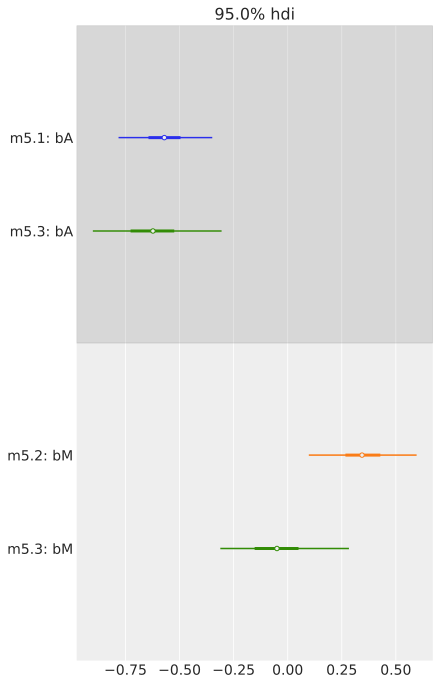

In [101]:
coeftab = {"m5.1": m5_1.sample_posterior(PRNGKey(1), p5_1, (1000,)),
           "m5.2": m5_2.sample_posterior(PRNGKey(2), p5_2, (1000,)),
           "m5.3": m5_3.sample_posterior(PRNGKey(3), p5_3, (1000,))}
az.plot_forest(list(coeftab.values()), model_names=list(coeftab.keys()),
               var_names=["bA", "bM"], hdi_prob=0.95);

### Code 5.12

In [107]:
N = 50  # number of simulated States, (American States)
age = dist.Normal().sample(PRNGKey(0), sample_shape=(N,))  # sim A
mar = dist.Normal(age).sample(PRNGKey(13))  # sim A -> M
div = dist.Normal(age).sample(PRNGKey(23))  # sim A -> D

### Code 5.13

In [108]:
def model(A, M=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bAM * A
    # even though we don't use "mu" again in the model, this makes it a site that we can observe later. 
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("M", dist.Normal(mu, sigma), obs=M)

### Code 5.14

In [109]:
# this is run using simulated data where D <- A -> M 
# the model is N(mu_D, sigma) where mu_D ~ N(0,0.2) + N(0, 0.5) * Age, sigma ~ Exp(1)


m5_4j = AutoLaplaceApproximation(model)
# m5_4j will be optimized to approximate 'model'
# the model is given by the above function which uses the schema D ~ N(m_D, sigma) | m_D ~ N(0,?)*Age + N(0,?)
svi = SVI(model, m5_4j, optim.Adam(0.1), AutoContinuousELBO(),
          A=age, M=mar)

init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_4j = svi.get_params(state)

post = m5_4j.sample_posterior(PRNGKey(1), p5_4j, (1000,))
post_pred = Predictive(m5_4j.model, post).get_samples(PRNGKey(2), A=age)

mu = post_pred["mu"]
mu_mean = np.mean(mu, 0)
mu_resid = d.M.values - mu_mean

print_summary(post, 0.89, False)
# 


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.10      0.13     -0.09     -0.31      0.10    931.50      1.00
        bA      0.76      0.18      0.75      0.45      1.04   1108.47      1.00
     sigma      1.19      0.12      1.18      1.00      1.38    937.26      1.00



In [110]:
m5_4 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_4, optim.Adam(0.1), AutoContinuousELBO(),
          A=d.A.values, M=d.M.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_4 = svi.get_params(state)

In [171]:
post = m5_4.sample_posterior(PRNGKey(1), p5_4, (1000,))
post_pred = Predictive(m5_4.model, post).get_samples(PRNGKey(2), A=d.A.values)
mu = post_pred["mu"]
mu_mean = np.mean(mu, 0)
mu_resid = d.M.values - mu_mean

print_summary(post, 0.89, False)
# so divorce is inversely related to Age of Marriage



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.01      0.09      0.01     -0.14      0.14    931.50      1.00
        bA     -0.70      0.10     -0.70     -0.84     -0.53   1111.41      1.00
     sigma      0.69      0.07      0.69      0.59      0.82    955.95      1.00



### Code 5.15

In [221]:
# call predictive without specifying new data
# so it uses original data

# what is m5_3 ? 
## its the model...

# what is p5_3 ? 
## the parameters for the model and the data

# post is a sample from the posterior distribution over the model parameters
post = m5_3.sample_posterior(PRNGKey(1), p5_3, (int(1e4),))
## post['a'].shape = 10000

# predict divorce using derived coefficients with MarriageRates and Age of Marriage
post_pred = Predictive(m5_3.model, post).get_samples(
    PRNGKey(2), M=d.M.values, A=d.A.values) # d.shape == 50,16

# so why are there 1000,30 mu values?? <<
# it was 1000,50 I must have run post_pred some where else
# 50 comes from 
mu = post_pred["mu"] # mu.shape = (1000, 50) 

# summarize samples across cases
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)

# simulate observations
# again no new data, so uses original data
D_sim = post_pred["D"]
D_PI = np.percentile(D_sim, q=(5.5, 94.5), axis=0) #shape 2,50

### Code 5.17

In [225]:

res = pd.DataFrame( {"low":mu_PI[0], "hi":mu_PI[1], "pred":mu_mean, "actual":d.D, "state": d.Location})

base = alt.Chart(res)


line = base.mark_line(color="red").encode(
    x="actual:Q",
    y="actual:Q")

error = base.mark_errorbar().encode(
    x="actual:Q",
    y="low:Q",
    y2="hi:Q"
)

points = base.mark_point().encode(
    x="actual:Q",
    y="pred:Q",
    tooltip=["state", "pred","low","actual","hi"]).properties(width=700, title="Predictions vs Actual Divorce rates - Model 5.3  D <- A -> M ")


line + error + points

alt.LayerChart(...)

0.3776042 1.6542052962567926 [0.16074969 0.59077257]
0.34848094 1.544364307129516 [0.01779068 0.6754583 ]
0.124500245 0.6107158995476608 [-0.04340236  0.28635153]
0.79612106 2.0935692527659016 [0.4552165 1.1427219]
-0.36252517 -0.9270579482342192 [-0.5535124 -0.1695941]
0.13100146 1.0500798560567686 [-0.10790516  0.3666947 ]
-0.7378957 -1.6410243775615203 [-1.0064448  -0.46470827]
-0.31663862 -0.43277349716147195 [-0.63677645 -0.00166147]
-1.8033986 -1.8607063558160746 [-2.4399164 -1.1580104]
-0.13236456 -0.6524554754160263 [-0.36084557  0.09461819]
0.04949039 0.9951593614931303 [-0.1456741   0.23957027]
-0.49234205 -0.7622964645433031 [-0.96294737 -0.02426602]
1.3581562 -1.0918194319251346 [0.92333364 1.8018004 ]
-0.4467766 -0.9270579482342192 [-0.6522755  -0.23832658]
0.18169788 0.7205568886749375 [-0.00084345  0.3609749 ]
0.30944517 0.2811929321658287 [0.12141483 0.49042788]
0.50261116 0.5008749104203831 [0.28434455 0.7221655 ]
0.6019345 1.5992848016931542 [0.36173722 0.84396446]
0.

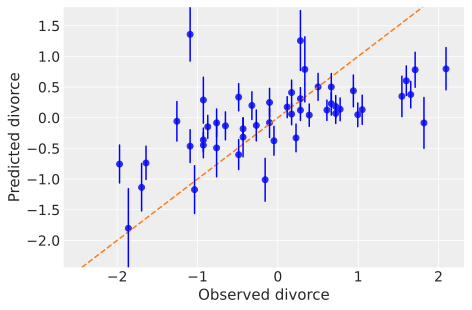

In [202]:
ax = plt.subplot(ylim=(float(mu_PI.min()), float(mu_PI.max())),
                 xlabel="Observed divorce", ylabel="Predicted divorce")
plt.plot(d.D, mu_mean, "o")
x = np.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
    print(mu_mean[i], d.D[i], mu_PI[:,i])
fig = plt.gcf()

In [157]:
d#.mu_mean
# dots = alt.Chart(d.assign(mu_mean= mu_mean))

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D,M
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000,-0.606290,1.654205,0.022644
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000,-0.686699,1.544364,1.549802
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000,-0.204241,0.610716,0.048974
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000,-1.410387,2.093569,1.655123
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000,0.599857,-0.927058,-0.266989
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000,-0.284651,1.050080,0.891544
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000,1.243135,-1.641024,-0.793595
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000,0.439037,-0.432773,0.786223
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000,2.931739,-1.860706,-0.635614
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000,0.278218,-0.652455,-0.819926


### Code 5.17

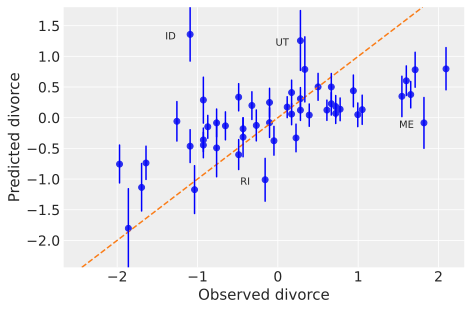

In [114]:
for i in range(d.shape[0]):
    if d.Loc[i] in ["ID", "UT", "RI", "ME"]:
        ax.annotate(d.Loc[i], (d.D[i], mu_mean[i]), xytext=(-25, -5),
                    textcoords="offset pixels")
fig

### Code 5.18

In [115]:
N = 100  # number of cases
# x_real as Gaussian with mean 0 and stddev 1
x_real = dist.Normal().sample(PRNGKey(0), (N,))
# x_spur as Gaussian with mean=x_real
x_spur = dist.Normal(x_real).sample(PRNGKey(1))
# y as Gaussian with mean=x_real
y = dist.Normal(x_real).sample(PRNGKey(2))
# bind all together in data frame
d = pd.DataFrame({"y": y, "x_real": x_real, "x_spur": x_spur})

### Code 5.19

In [300]:
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

# what really comes out of this function are distributions over the coefficients aM, bAM, sigmaM, a, bM, bA and M and D if the 
# latter two aren't specified.
def model(A, M=None, D=None):
    # a___ means intercept
    # b___ means slope (in these models)
    # M is the marriage rate
    # AM is the AgeOfMarriage (median)
    
    # we assume all input data has been normalized so a__input == 0 
    # A -> M
    
    aM = numpyro.sample("aM", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bAM", dist.Normal(0, 0.5))
    sigma_M = numpyro.sample("sigma_M", dist.Exponential(1))
    
    # we model mu_M the average marriage rate as linear function of the age of marriage, A
    # A is always given
    mu_M = aM + bAM * A
    
    # if the observation M is given then M <- observation M and we generate likelihoods for mu_M, and sigma_M ,
    # otherwise, M is generate from N(mu_M, sigma) each of which have their own priors/turtles 
    M = numpyro.sample("M", dist.Normal(mu_M, sigma_M), obs=M)
    
    # A -> D <- M
    # OF NOTE: there are two independent models in here A -> M, and A -> D <- M
    
    # a is Divorce intercept
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    
    # bM is slope Marriage rate
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    # bA is slope Age for 
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    
    # if D is given then we get the likelihood of the mu and sigma params.
    # if not, we simply generate D from the priors.
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_3_A = AutoLaplaceApproximation(model)
# create Stochastic Variable Inference object with data for AgeMedian, Marriage Rates and Divorce Rates
svi = SVI(model, m5_3_A, optim.Adam(0.1), AutoContinuousELBO(),
          A=d.A.values, M=d.M.values, D=d.D.values)

init_state = svi.init(PRNGKey(0))
# svi.update(x) returns (state, loss) --- lambda throws away i  
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_3_A = svi.get_params(state)

In [301]:
# these are the parameters we would feed to an AutoLaplaceApproximation model to approximate the distribution implied by model.
p5_3_A

{'auto_loc': DeviceArray([-7.1592177e-09,  2.4466939e-08, -6.1232036e-01,
              -6.9422877e-01, -6.4499617e-02, -2.3199466e-01,
              -3.7318882e-01], dtype=float32)}

> example of lax.scan

In [302]:
_f = lambda x, i: (x * i, i )
#  scan :: (acc -> arg -> (acc, res)) -> acc_init -> [list of args] -> (c, [list of results]) 
lax.scan( _f, 1.0, 1+np.arange(20))

(DeviceArray(2.432902e+18, dtype=float32),
 DeviceArray([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
              16, 17, 18, 19, 20], dtype=int32))

### Code 5.20

In [303]:
A_seq = np.linspace(-2, 2, num=30)

### Code 5.21

In [343]:
# prep data
sim_dat = dict(A=A_seq)
# simulate M and then D, using A_seq

# post is a 1000 samples generated from the LaplaceApproximation function for the samples
post = m5_3_A.sample_posterior(PRNGKey(1), p5_3_A, (1000,))

# using the generated distributions for the sample parameters AND the sim_dat, first generate M (which does not depend on D), and then
# generate D which depends on both A and M
# in this case "s" is the predicted D using synthetic A

# note: 
s = Predictive(m5_3_A.model, post).get_samples(PRNGKey(2), **sim_dat)

In [344]:
# these are the samples for which no data was given. thus A,M and D are excluded.
print(post.keys())

post['a'].shape

dict_keys(['a', 'aM', 'bA', 'bAM', 'bM', 'sigma', 'sigma_M'])


(1000,)

In [345]:
# shape is 1000, 30 because there are 30 different values for A

# lets think about this... before we had a 1000 different tuples of (aM, bM, etc)
# each aM had its distinct bM etc. 
# when we're generating our tuples we're generating them from our approximating distribution
# using the given data A,M and D. 

# when we simulate data using A, we use the parameters derived from the model to recreate M, and then
# we recreate D using 
s.keys(), s['D'].shape

(dict_keys(['D', 'M']), (1000, 30))

### Code 5.22

What does this mean _manipulated_? it means we modify its values _ignoring_ any correlation that it may have with other "independant" variables.

In the example of the espresso machine, it could mean adjusting the water pressure gauge. Which, of course, would have no effect on the actual brew.
Or is it just ignoring "backdoor" effects? This would still allow our espresso example. 

In the example below we are asking: What is the effect of manipulating the age of median age of marriage. Obviously, one cannot actually do such a thing 
but if we could then $D$ would not be a counterfactual, it would be a controlled experiment.

In the graph below, we see that increasing the median age of marriage decreases the divorce rate. 


how is this different from just looking at a graph of actual divorce rates as a function of A different ?

In [346]:
_pi = np.percentile(s["D"], q=(5.5, 94.5), axis=0)
_df = pd.DataFrame(dict(A=sim_dat["A"], Dm = np.mean(s["D"],0), lo = _pi[0], hi = _pi[1]))
base = alt.Chart(_df)
line = base.mark_line().encode(x = "A", y = "Dm")
area = base.mark_area(opacity=0.2).encode(x = alt.X("A", title="manipulated A"), y = alt.Y("lo:Q", title="counterfactual D"), y2 = "hi:Q")
cfact = (line + area).properties(title = "Total counterfactual effect of A on D", width=800)
cfact

alt.LayerChart(...)

### So what does the actual data show as a scatter plot of D ~ A 

Below is a plot of the actual divorce stats relative to actual AgeMedian of marriage on top 
of the counterfactual plot of "what if" A was ...



In [347]:
D_A_c = cfact + alt.Chart(d).mark_point().encode( x = "A:Q", y = "D:Q", tooltip=["Location"]).properties(width=800, )
D_A_c

alt.LayerChart(...)

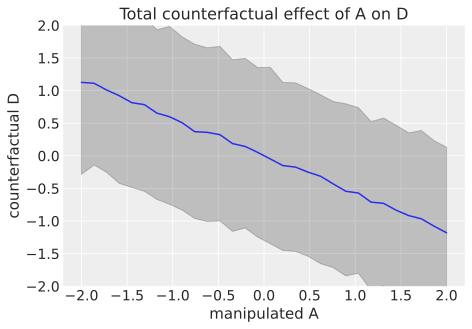

In [25]:
# display counterfactual predictions
plt.plot(sim_dat["A"], np.mean(s["D"], 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(sim_dat["A"], *np.percentile(s["D"], q=(5.5, 94.5), axis=0),
                 color="k", alpha=0.2)
plt.title("Total counterfactual effect of A on D");

### Code 5.23

In [310]:
sim_dat = dict(M=np.linspace(-2, 2, num=30), A=0)
s = Predictive(m5_3_A.model, post).get_samples(PRNGKey(2), **sim_dat)#["D"]

_pi = np.percentile(s["D"], q=(5.5, 94.5), axis=0)
_df = pd.DataFrame(dict(A=sim_dat["M"], Dm = np.mean(s["D"],0), lo = _pi[0], hi = _pi[1]))
base = alt.Chart(_df)
line = base.mark_line().encode(x = "A", y = "Dm")
area = base.mark_area(opacity=0.2).encode(x = alt.X("A", title="manipulated M"), y = alt.Y("lo:Q", title="counterfactual D"), y2 = "hi:Q")
cfact = (line + area).properties(title = "Total counterfactual effect of M on D", width=800)
cfact + alt.Chart(d).mark_point().encode( x = "M:Q", y = "D:Q", tooltip= ["Location"]).properties(width=800, )

alt.LayerChart(...)

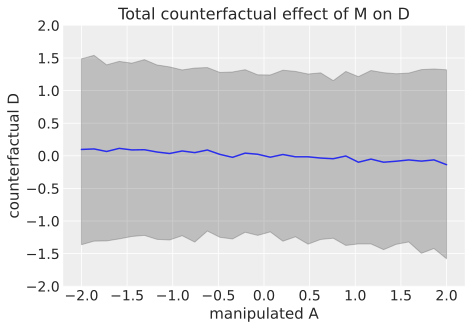

In [26]:
sim_dat = dict(M=np.linspace(-2, 2, num=30), A=0)
s = Predictive(m5_3_A.model, post).get_samples(PRNGKey(2), **sim_dat)["D"]

plt.plot(sim_dat["M"], np.mean(s, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(sim_dat["M"], *np.percentile(s, q=(5.5, 94.5), axis=0),
                 color="k", alpha=0.2)
plt.title("Total counterfactual effect of M on D");

### Code 5.24

In [314]:
A_seq = np.linspace(-2, 2, num=30)

### Code 5.25

In [350]:
post = m5_3_A.sample_posterior(PRNGKey(1), p5_3_A, (1000,))
print(post.keys())
post = {k: v[..., None] for k, v in post.items()}
M_sim = dist.Normal(post["aM"] + post["bAM"] * A_seq).sample(PRNGKey(1))

# M_sim shape 1000,30
(lo, hi) = np.percentile(M_sim, q=(5.5, 94.5), axis=0)
M_sim_mean = M_sim.mean(0)
_df = pd.DataFrame(dict(m=M_sim_mean, lo=lo, hi=hi, a = A_seq))

base_c = alt.Chart(_df)
area_c = base_c.mark_area(opacity=0.4).encode(y="lo:Q", y2="hi:Q", x = "a:Q")
line_c = base_c.mark_line().encode(x = "a:Q", y="m:Q")
actual_c = alt.Chart(d).mark_point().encode(x = "A:Q", y = "D:Q", tooltip=["Location"])
# area_c + line_c
(area_c + line_c + actual_c).properties(width= 800, title="Counterfactual Marriage rate ~ Manipulated Marriage Age")

dict_keys(['a', 'aM', 'bA', 'bAM', 'bM', 'sigma', 'sigma_M'])


alt.LayerChart(...)

In [348]:
D_A_c

alt.LayerChart(...)

### Code 5.26

In [313]:
D_sim = dist.Normal(post["a"] + post["bA"] * A_seq + post["bM"] * M_sim).sample(
    PRNGKey(1))

In [351]:
post = m5_3_A.sample_posterior(PRNGKey(1), p5_3_A, (1000,))
print(post.keys())
post = {k: v[..., None] for k, v in post.items()}
# M_sim = dist.Normal(post["aM"] + post["bAM"] * A_seq).sample(PRNGKey(1))

# note we use M_sim here !!
D_sim = dist.Normal(post["a"] + post["bA"] * A_seq + post["bM"] * M_sim).sample(
    PRNGKey(1))

# M_sim shape 1000,30
(lo, hi) = np.percentile(D_sim, q=(5.5, 94.5), axis=0)
D_sim_mean = D_sim.mean(0)
_df = pd.DataFrame(dict(m=D_sim_mean, lo=lo, hi=hi, a = A_seq))

base_c = alt.Chart(_df)
area_c = base_c.mark_area(opacity=0.4).encode(y="lo:Q", y2="hi:Q", x = "a:Q")
line_c = base_c.mark_line().encode(x = "a:Q", y="m:Q")
actual_c = alt.Chart(d).mark_point().encode(x = "A:Q", y = "D:Q", tooltip=["Location"])
# area_c + line_c
(area_c + line_c + actual_c).properties(width= 800, title="Counterfactual Divorce Rate ~ Manipulated Marriage Age + Simulated Marriage Rate")

dict_keys(['a', 'aM', 'bA', 'bAM', 'bM', 'sigma', 'sigma_M'])


alt.LayerChart(...)

### Code 5.27

In [30]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### Code 5.28

In [31]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["N"] = d["neocortex.perc"].pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.mass.pipe(onp.log).pipe(lambda x: (x - x.mean()) / x.std())

### Code 5.29

In [32]:
def model(N, K):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bN = numpyro.sample("bN", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

with numpyro.validation_enabled():
    try:
        m5_5_draft = AutoLaplaceApproximation(model)
        svi = SVI(model, m5_5_draft, optim.Adam(1), AutoContinuousELBO(),
                  N=d.N.values, K=d.K.values)
        init_state = svi.init(PRNGKey(0))
        state, loss = lax.scan(
            lambda x, i: svi.update(x), init_state, np.zeros(1000))
        p5_5_draft = svi.get_params(state)
    except ValueError as e:
        print(str(e))

The parameter loc has invalid values


### Code 5.30

In [34]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### Code 5.31

In [35]:
dcc = d.iloc[d[["K", "N", "M"]].dropna(how="any", axis=0).index]

### Code 5.32

In [36]:
def model(N, K=None):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bN = numpyro.sample("bN", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

m5_5_draft = AutoLaplaceApproximation(model)
svi = SVI(model, m5_5_draft, optim.Adam(0.1), AutoContinuousELBO(),
          N=dcc.N.values, K=dcc.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_5_draft = svi.get_params(state)

### Code 5.33

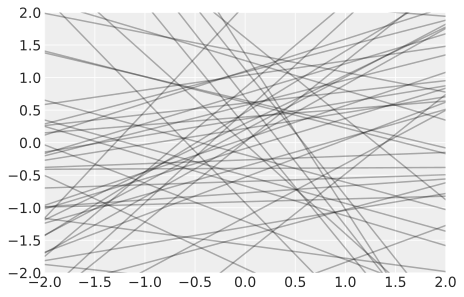

In [37]:
xseq = np.array([-2, 2])
prior_pred = Predictive(model, num_samples=1000).get_samples(
    PRNGKey(1), N=xseq)
mu = prior_pred["mu"]
plt.subplot(xlim=xseq, ylim=xseq)
for i in range(50):
    plt.plot(xseq, mu[i], "k", alpha=0.3)

### Code 5.34

In [38]:
def model(N, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

m5_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_5, optim.Adam(1), AutoContinuousELBO(),
          N=dcc.N.values, K=dcc.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_5 = svi.get_params(state)

### Code 5.35

In [39]:
post = m5_5.sample_posterior(PRNGKey(1), p5_5, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.05      0.16      0.05     -0.21      0.29    931.50      1.00
        bN      0.13      0.23      0.13     -0.21      0.53   1111.88      1.00
     sigma      1.05      0.18      1.03      0.78      1.35    944.03      1.00



### Code 5.36

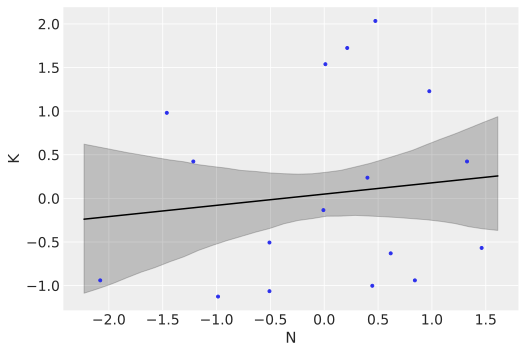

In [40]:
xseq = np.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
post = m5_5.sample_posterior(PRNGKey(1), p5_5, (1000,))
post_pred = Predictive(m5_5.model, post).get_samples(PRNGKey(2), N=xseq)
mu = post_pred["mu"]
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)
az.plot_pair(dcc[["N", "K"]].to_dict(orient="list"))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);

### Code 5.37

In [41]:
def model(M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

m5_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_6, optim.Adam(1), AutoContinuousELBO(),
          M=dcc.M.values, K=dcc.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_6 = svi.get_params(state)
post = m5_6.sample_posterior(PRNGKey(1), p5_6, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.16      0.06     -0.20      0.29    931.50      1.00
        bM     -0.28      0.20     -0.28     -0.61      0.03   1088.44      1.00
     sigma      0.99      0.17      0.98      0.72      1.26    957.10      1.00



### Code 5.38

In [42]:
def model(N, M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N + bM * M
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

m5_7 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_7, optim.Adam(1), AutoContinuousELBO(),
          N=dcc.N.values, M=dcc.M.values, K=dcc.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_7 = svi.get_params(state)
post = m5_7.sample_posterior(PRNGKey(1), p5_7, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.13      0.06     -0.15      0.26   1049.96      1.00
        bM     -0.68      0.23     -0.68     -1.06     -0.32    837.54      1.00
        bN      0.65      0.25      0.66      0.25      1.06    885.39      1.00
     sigma      0.77      0.14      0.77      0.55      0.97   1029.58      1.00



### Code 5.39

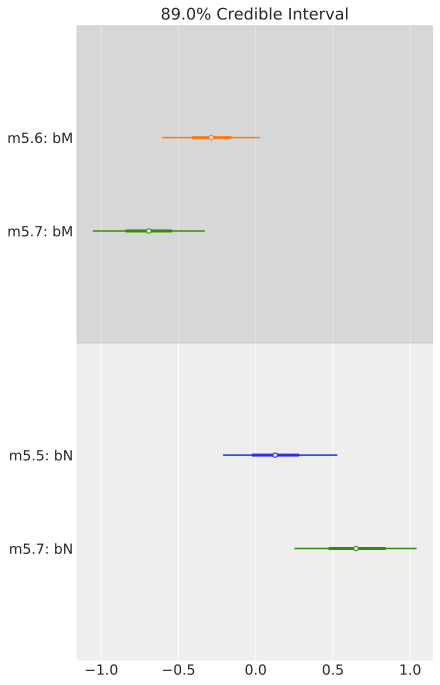

In [43]:
coeftab = {"m5.5": m5_5.sample_posterior(PRNGKey(1), p5_5, (1000,)),
           "m5.6": m5_6.sample_posterior(PRNGKey(2), p5_6, (1000,)),
           "m5.7": m5_7.sample_posterior(PRNGKey(3), p5_7, (1000,))}
az.plot_forest(list(coeftab.values()), model_names=list(coeftab.keys()),
               var_names=["bM", "bN"], credible_interval=0.89);

### Code 5.40

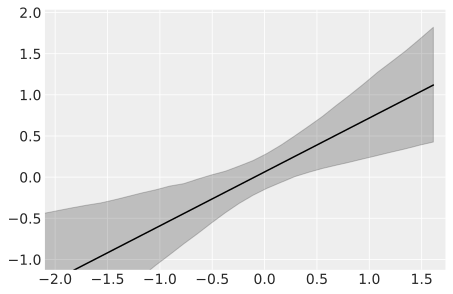

In [44]:
xseq = np.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
post = m5_7.sample_posterior(PRNGKey(1), p5_7, (1000,))
post_pred = Predictive(m5_7.model, post).get_samples(PRNGKey(2), M=0, N=xseq)
mu = post_pred["mu"]
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)
plt.subplot(xlim=(dcc.M.min(), dcc.M.max()), ylim=(dcc.K.min(), dcc.K.max()))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);

### Code 5.41

In [45]:
# M -> K <- N
# M -> N
n = 100
M = dist.Normal().sample(PRNGKey(0), (n,))
N = dist.Normal(M).sample(PRNGKey(1))
K = dist.Normal(N - M).sample(PRNGKey(2))
d_sim = pd.DataFrame({"K": K, "N": N, "M": M})

### Code 5.42

In [46]:
# M -> K <- N
# N -> M
n = 100
N = dist.Normal().sample(PRNGKey(0), (n,))
M = dist.Normal(N).sample(PRNGKey(1))
K = dist.Normal(N - M).sample(PRNGKey(2))
d_sim2 = pd.DataFrame({"K": K, "N": N, "M": M})

# M -> K <- N
# M <- U -> N
n = 100
N = dist.Normal().sample(PRNGKey(3), (n,))
M = dist.Normal(M).sample(PRNGKey(4))
K = dist.Normal(N - M).sample(PRNGKey(5))
d_sim3 = pd.DataFrame({"K": K, "N": N, "M": M})

### Code 5.43

In [47]:
dag5_7 = CausalGraphicalModel(
    nodes=["M", "K", "N"],
    edges=[("M", "K"),
           ("N", "K"),
           ("M", "N")])
coordinates = {"M": (0, 0.5), "K": (1, 1), "N": (2, 0.5)}
nodes = list(dag5_7.dag.nodes.keys())
edges = list(dag5_7.dag.edges.keys())
MElist = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            try:
                new_dag = CausalGraphicalModel(
                    nodes=nodes,
                    edges=[edges[0] if i == 0 else edges[0][::-1],
                       edges[1] if j == 0 else edges[1][::-1],
                       edges[2] if k == 0 else edges[2][::-1]])
                MElist.append(new_dag)
            except:
                pass

### Code 5.44

In [48]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Code 5.45

In [49]:
mu_female = dist.Normal(178, 20).sample(PRNGKey(0), (int(1e4),))
diff = dist.Normal(0, 10).sample(PRNGKey(1), (int(1e4),))
mu_male = dist.Normal(178, 20).sample(PRNGKey(2), (int(1e4),)) + diff
print_summary({"mu_female": mu_female, "mu_male": mu_male}, 0.89, False)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
  mu_female    178.21     20.22    178.24    147.19    211.84   9943.61      1.00
    mu_male    178.10     22.36    178.51    142.35    213.41  10190.57      1.00



### Code 5.46

In [50]:
d["sex"] = np.where(d.male.values == 1, 1, 0)
d.sex

0      1
1      0
2      0
3      1
4      0
      ..
539    1
540    1
541    0
542    1
543    1
Name: sex, Length: 544, dtype: int32

### Code 5.47

In [51]:
def model(sex, height):
    a = numpyro.sample("a", dist.Normal(178, 20), sample_shape=(len(set(sex)),))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a[sex]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m5_8 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_8, optim.Adam(1), AutoContinuousELBO(),
          sex=d.sex.values, height=d.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p5_8 = svi.get_params(state)
post = m5_8.sample_posterior(PRNGKey(1), p5_8, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



### Code 5.48

In [52]:
post = m5_8.sample_posterior(PRNGKey(1), p5_8, (1000,))
post["diff_fm"] = post["a"][:, 0] - post["a"][:, 1]
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
   diff_fm     -7.54      2.38     -7.47    -11.77     -4.32    876.56      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



### Code 5.49

In [53]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

### Code 5.50

In [54]:
d["clade_id"] = d.clade.astype("category").cat.codes

### Code 5.51

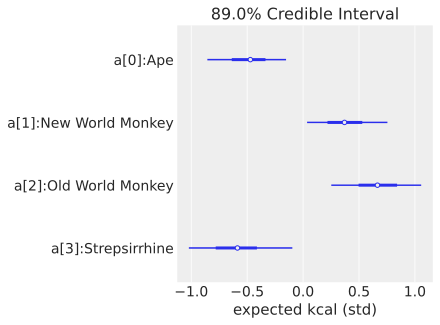

In [55]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())

def model(clade_id, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5),
                     sample_shape=(len(set(clade_id)),))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[clade_id]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=K)

m5_9 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_9, optim.Adam(1), AutoContinuousELBO(),
          clade_id=d.clade_id.values, K=d.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_9 = svi.get_params(state)
post = m5_9.sample_posterior(PRNGKey(1), p5_9, (1000,))
labels = ["a[" + str(i) + "]:" + s
          for i, s in enumerate(sorted(d.clade.unique()))]
az.plot_forest({"a": post["a"][None, ...]}, credible_interval=0.89)
plt.gca().set(yticklabels=labels[::-1], xlabel="expected kcal (std)");

### Code 5.52

In [58]:
onp.random.seed(63)
d["house"] = onp.random.choice(np.repeat(np.arange(4), 8), d.shape[0], False)

### Code 5.53

In [57]:
def model(clade_id, house, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5),
                     sample_shape=(len(set(clade_id)),))
    h = numpyro.sample("h", dist.Normal(0, 0.5),
                     sample_shape=(len(set(house)),))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[clade_id] + h[house]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=K)

m5_10 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_10, optim.Adam(1), AutoContinuousELBO(),
          clade_id=d.clade_id.values, house=d.house.values, K=d.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_10 = svi.get_params(state)